# Introduction
In this small project we will take a look at Seattle weather dataset from Kaggle to extract important features and use them to test functionality of Recurrent Neural Network.
<br><br>
#### Main objective
Build a model using PyTorch library that predicts temperature for the next day.
<br><br>
#### Process includes:
1. **Data** <br>
&ensp;1.1 Overview <br>
&ensp;1.2 Anomalies <br>
&ensp;1.3 Visualization <br>
&ensp;1.4 Preparing data for model <br>
2. **Building model** <br>
&ensp;2.1 Train / test split <br>
&ensp;2.2 Sequencing datasets <br>
&ensp;2.3 Class LSTM <br>
&ensp;2.4 Training function <br>
&ensp;2.5 Testing function <br>
&ensp;2.6 Training and Testing the RNN models <br>
3. **Conclusion**

#### Setup

In [1]:
import matplotlib.pyplot as plt

WHITE_MID = '#b5b5b5'
GREY_DARK = '#141414'

plt.rcParams['figure.facecolor'] = GREY_DARK
plt.rcParams['text.color'] = WHITE_MID
plt.rcParams['axes.facecolor'] = GREY_DARK
plt.rcParams['axes.edgecolor'] = WHITE_MID
plt.rcParams['axes.labelcolor'] = WHITE_MID
plt.rcParams['axes.titlecolor'] = WHITE_MID

plt.rcParams['grid.color'] = WHITE_MID
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.color'] = WHITE_MID
plt.rcParams['ytick.color'] = WHITE_MID
plt.rcParams['legend.edgecolor'] = WHITE_MID
plt.rcParams['legend.labelcolor'] = WHITE_MID

In [2]:
import numpy as np
import torch
import random
import warnings

warnings.filterwarnings("ignore")

seed = 42

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# I - Data
#### 1.1 Overview
To preview dataset we're going to use pandas library. <br><br>
Following authors description: <br><br>
**_precipitation_** - all forms in which water falls on the land surface and open water bodies as rain, sleet, snow, hail, or drizzle <br>
**_temp_max_** - highest temperature recorded that day <br>
**_temp_min_** - lowest temperature recorded that day <br>
**_wind_** - wind speed <br>
**_weather_** - weather condition <br>

In [3]:
import pandas as pd

df = pd.read_csv('../datasets/weather-raw.csv')
df

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [4]:
df['date'] = pd.to_datetime(df['date']) # convert date to actual date format
df.set_index('date', inplace=True) # attach it as index column

In [5]:
df.isna().sum() # search for nulls

precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [6]:
df[df.duplicated(keep=False)].sort_values(by=['temp_max', 'wind'], ascending=False) # search for duplicates, sort it first by temp_avg, then by wind

,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2014-07-14,0.0,27.8,15.0,2.8,sun
2014-08-17,0.0,27.8,15.0,2.8,sun
2012-05-14,0.0,26.7,12.8,3.8,sun
2012-07-07,0.0,26.7,12.8,3.8,sun
2014-05-13,0.0,26.7,12.8,3.8,sun
2012-08-29,0.0,22.8,13.3,2.4,sun
2015-09-08,0.0,22.8,13.3,2.4,sun
2013-09-18,0.0,21.1,13.3,2.5,sun
2013-09-21,0.0,21.1,13.3,2.5,sun


In [7]:
if bool(len(df[df['temp_min'] >= df['temp_max']])): # temp_min >= temp_max
    df[df.temp_min >= df.temp_max]
elif len(df[(df.wind < 0) | (df.precipitation < 0)]): # negative values in wind and precipitation columns
    df[(df.wind < 0) | (df.precipitation < 0)]
else:
    pass

"rainy" weather but no actual rain.

In [8]:
df_rainy = df['weather'] == 'rain'
df_noprecip = df['precipitation'] == 0
print(len(df[(df_rainy) & (df_noprecip)]))
df[(df_rainy) & (df_noprecip)].head()

44


,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2012-01-07,0.0,7.2,2.8,2.3,rain
2012-01-23,0.0,8.3,1.1,3.6,rain
2012-01-28,0.0,6.7,0.6,2.2,rain
2012-02-25,0.0,7.2,2.8,6.4,rain
2012-03-04,0.0,10.6,6.7,5.6,rain


It's sketchy, but I guess the weather 'rain' doesn't mean we have to expect rain that day but the 'feeling' of the weather.

#### 1.3 Visualization
Using different type of plots from seaborn to find correlations and patterns.

In [9]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


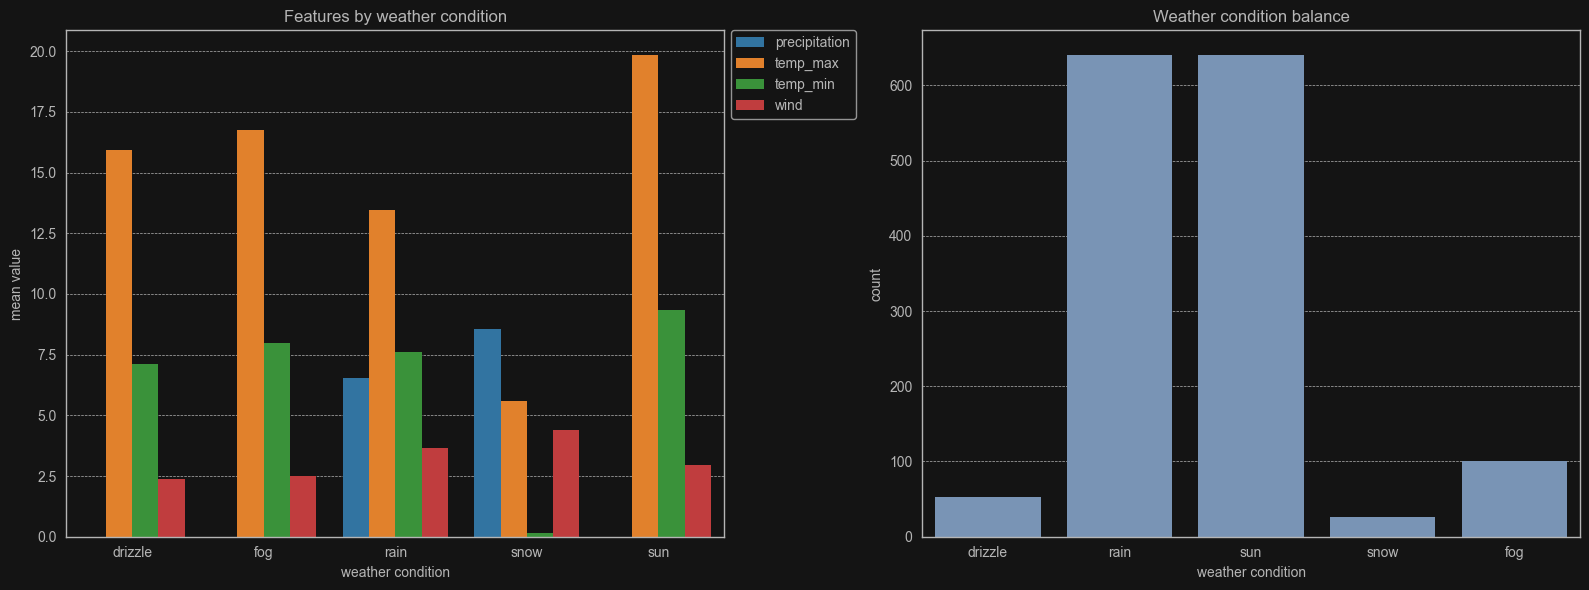

In [10]:
import seaborn as sb

mid_blue = '#6f93bf'
mid_red = '#bf6f6f'

mean_per_weather = df.groupby('weather').mean(numeric_only=True).reset_index()
melted = mean_per_weather.melt(id_vars='weather')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes = axes.flatten()

sb.barplot(data=melted, x='weather', y='value', hue='variable', linewidth=0, ax=axes[0])
axes[0].set_title('Features by weather condition')
axes[0].set_ylabel('mean value')
axes[0].set_xlabel('weather condition')
axes[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

sb.countplot(data=df, x='weather', color=mid_blue, edgecolor='none', ax=axes[1])
axes[1].set_title('Weather condition balance')
axes[1].set_xlabel('weather condition')

plt.tight_layout()

Text(0.5, 1.0, 'Correlation')

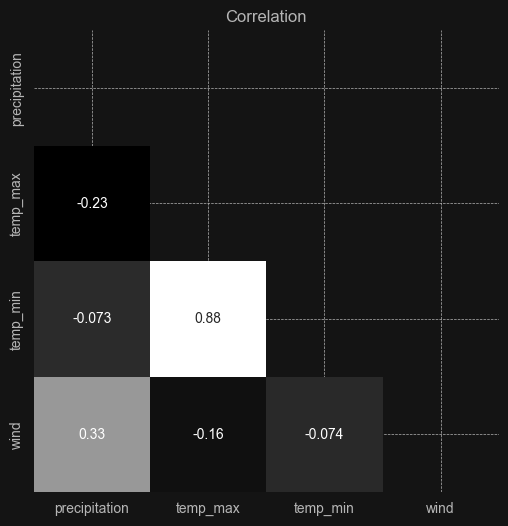

In [11]:
df = df.drop(['weather'], axis=1) # drop weather column

fig = plt.figure(figsize=(6, 6))
sb.heatmap(df.corr(), annot=True, cmap='Greys_r', cbar=False, mask=np.triu(np.ones(len(df.corr())), k=0))
plt.title('Correlation')

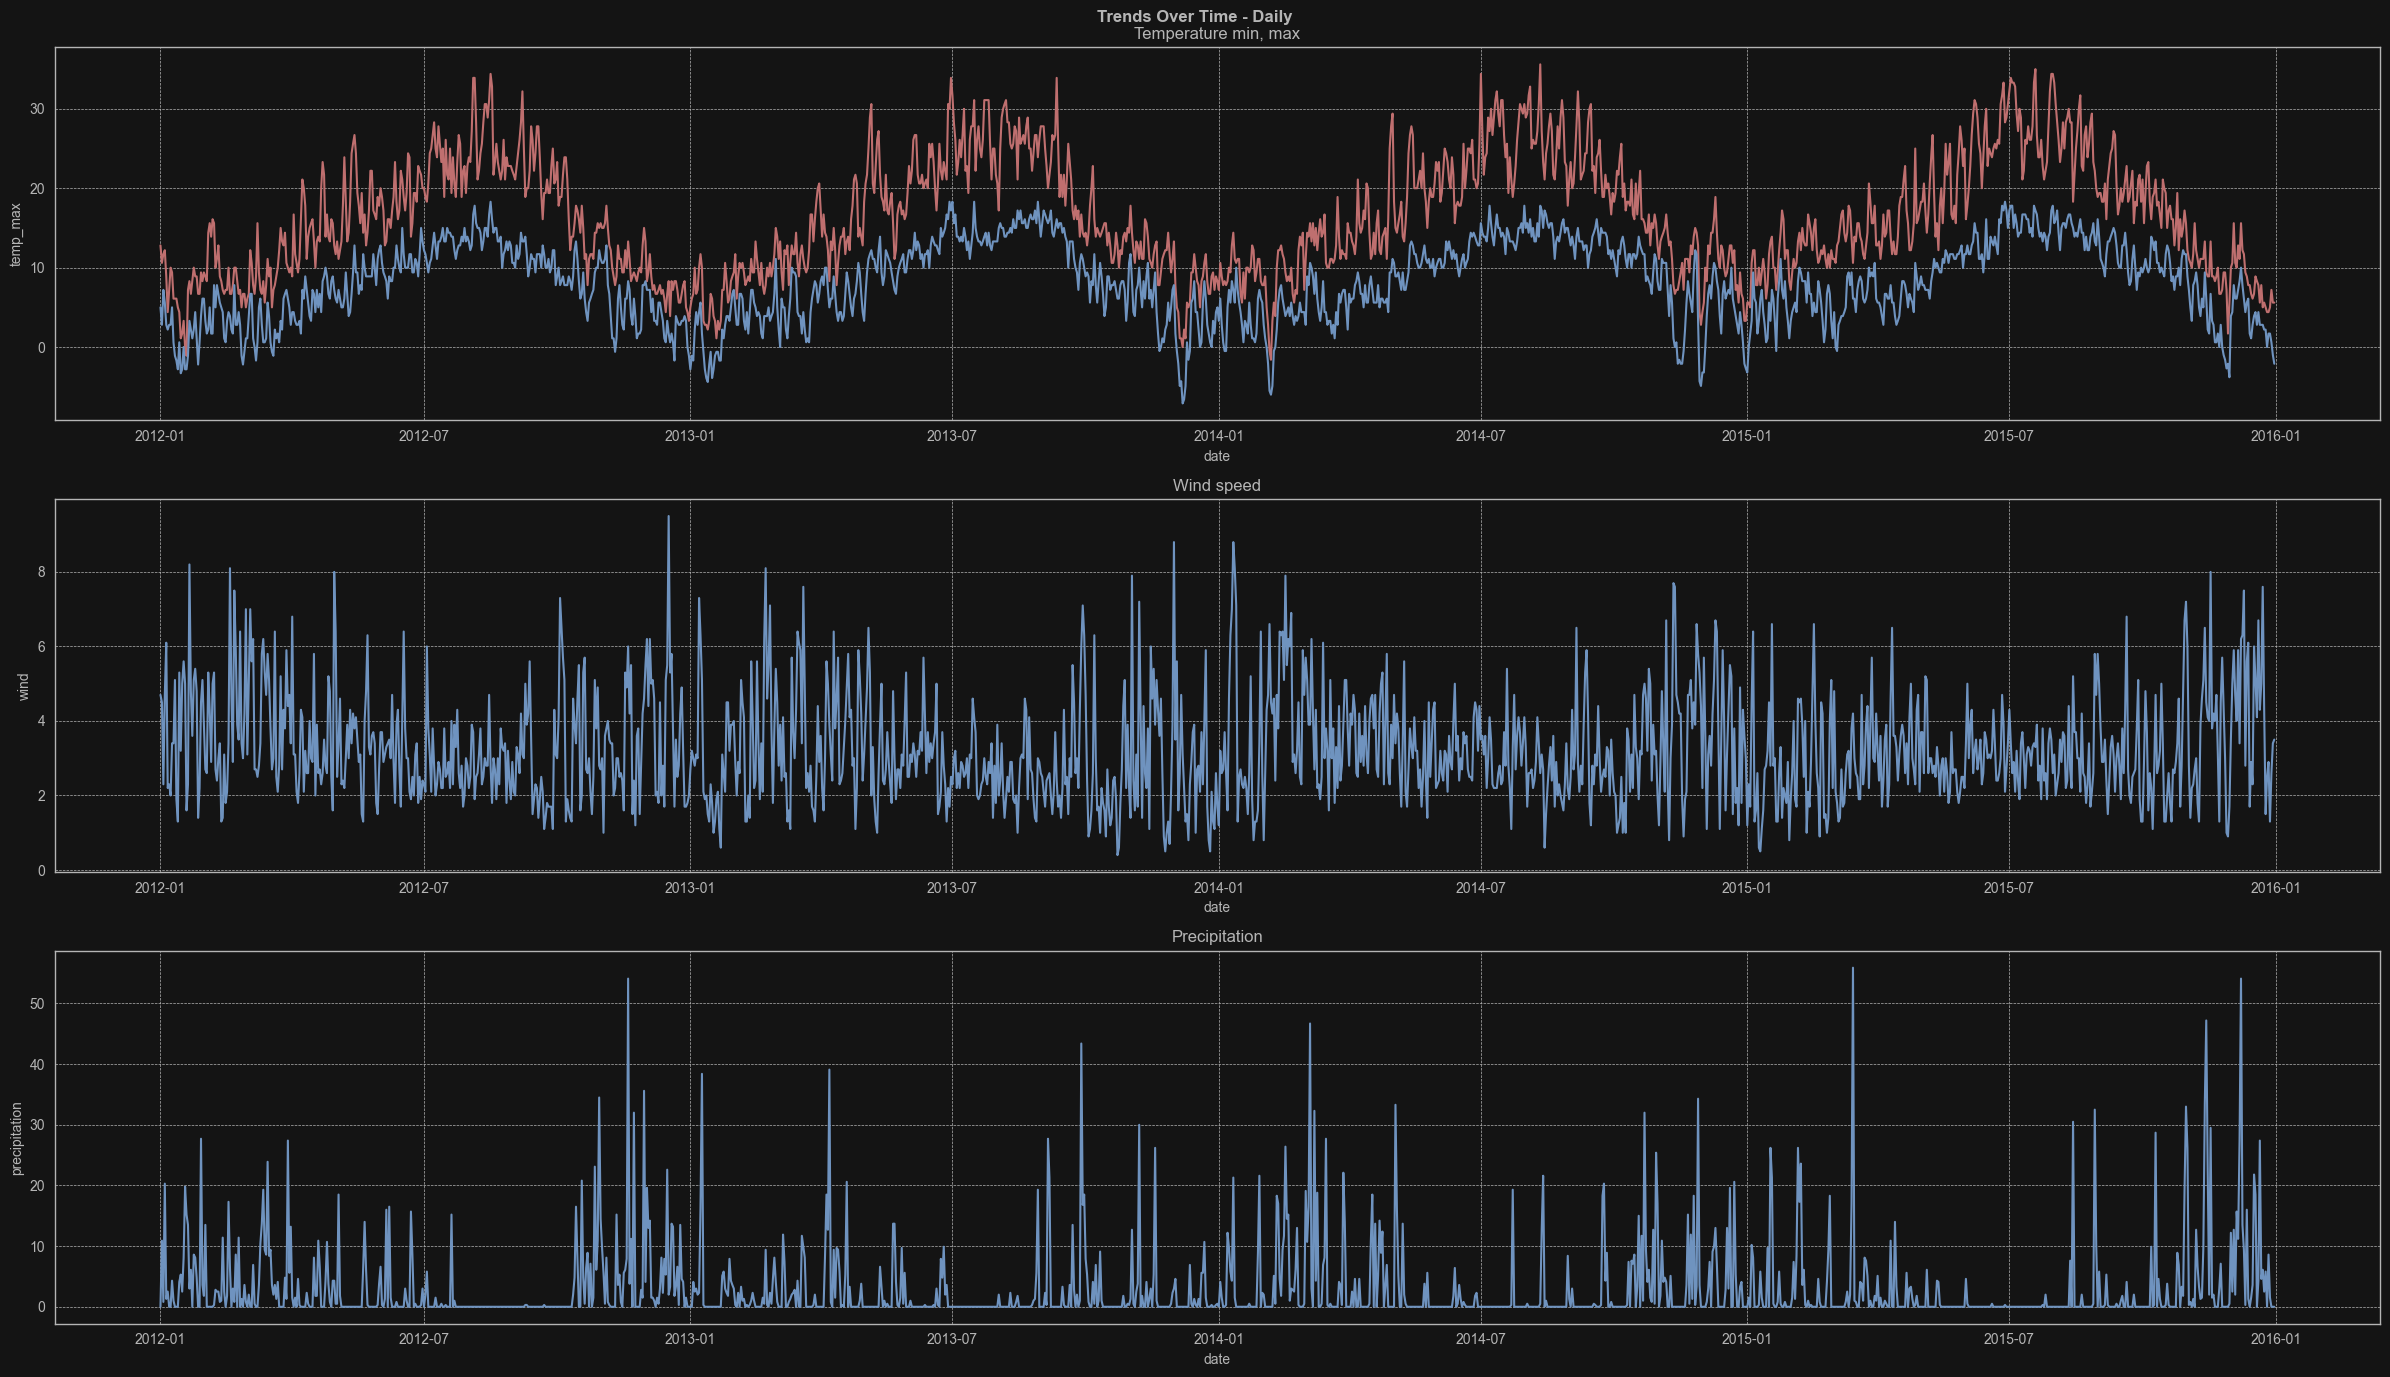

In [12]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(24, 14))
axes = axes.flatten()

sb.lineplot(data=df, x='date', y='temp_max', color=mid_red, ax=axes[0])
sb.lineplot(data=df, x='date', y='temp_min', color=mid_blue, ax=axes[0])
sb.lineplot(data=df, x='date', y='wind', color=mid_blue, ax=axes[1])
sb.lineplot(data=df, x='date', y='precipitation', color=mid_blue, ax=axes[2])

axes[0].set_title('Temperature min, max')
axes[1].set_title('Wind speed')
axes[2].set_title('Precipitation')

fig.suptitle('Trends Over Time - Daily', fontweight='bold')
plt.tight_layout()

Seasonal pattern suggests that more precipitations appear in autumn months.<br>
During winter season wind speed varies notably more comparing to summer season.<br><br>
Since both temp_min and temp_max change almost the same way, we can extract _**average temperature**_. <br>
This can reduce the number of values for the model to calculate and change the input size by removing redundant features.

In [13]:
temp_avg = df[['temp_max', 'temp_min']].mean(axis=1) # calculate mean
df.drop(['temp_max', 'temp_min'], axis=1, inplace=True)
df.insert(2, 'temp_avg', temp_avg)
df.head()

,precipitation,wind,temp_avg
date,,,
2012-01-01,0.0,4.7,8.90
2012-01-02,10.9,4.5,6.70
2012-01-03,0.8,2.3,9.45
2012-01-04,20.3,4.7,8.90
2012-01-05,1.3,6.1,5.85


In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = ['precipitation', 'temp_avg', 'wind']

df.loc[:, features] = scaler.fit_transform(df[features]) # applying scaled features to numeric features

df.describe()

,precipitation,wind,temp_avg
count,1461.000000,1461.000000,1461.000000
mean,0.054194,0.312213,0.529080
std,0.119503,0.158003,0.196657
min,0.000000,0.000000,0.000000
25%,0.000000,0.197802,0.378689
50%,0.000000,0.285714,0.516393
75%,0.050089,0.395604,0.688525
max,1.000000,1.000000,1.000000


#### Data seasonality

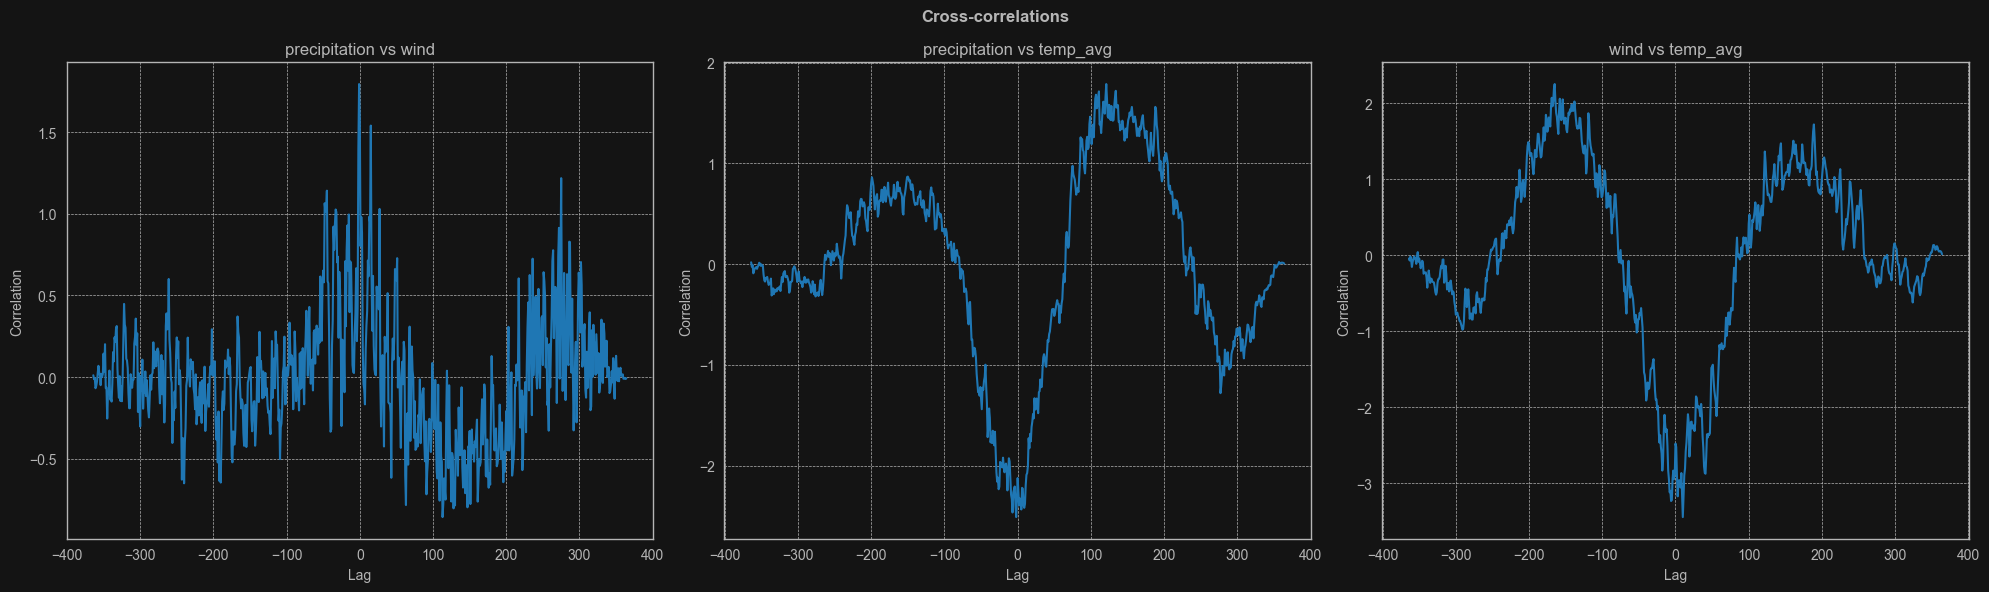

In [15]:
from scipy.signal import correlate
from itertools import combinations

year_i = 0
year_i *= 365
df_sample = df[year_i:year_i+365]

# selects numeric features
numeric_features = df.select_dtypes(include='number').columns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
axes = axes.flatten()

# enumerated iteration through combinations of numeric features
for i, comb in enumerate(combinations(numeric_features, r=2)):
    feat_a, feat_b = comb
    
    x = df_sample[feat_a] - np.mean(df_sample[feat_a]) # center feature a
    y = df_sample[feat_b] - np.mean(df_sample[feat_b]) # center feature b

    # cross correlation
    correlation = correlate(x, y, mode='full')
    lags = np.arange(-len(x) + 1, len(x))
    
    # plots
    axes[i].plot(lags, correlation)
    axes[i].set_title(f'{feat_a} vs {feat_b}')
    axes[i].set_xlabel('Lag')
    axes[i].set_ylabel('Correlation')

plt.suptitle('Cross-correlations', fontweight='bold')
plt.tight_layout()

#### 1.4 Granger causality
We check if one certain feature helps to predict average temperature. For this we can use Granger causality test. <br>
Despite the fact that it's more useful for linear models, I want to check if it actually gives any clues while choosing features for LSTM. <br>
To see whether the features are **stationary** or not we check the p-values from the _Dickey-Fuller's test_.

In [16]:
from statsmodels.tsa.stattools import grangercausalitytests as granger
from statsmodels.tsa.stattools import adfuller

features = ['wind', 'temp_avg', 'precipitation']

for feat in features:
    result = adfuller(df[feat])

    # create dictionary for adfuller's test
    output = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Used lags': result[2],
        'N obs': result[3],
        'Critical Values': result[4],
        'IC best (AIC)': result[5]
    }
    
    print(feat.upper())
    for k, v in output.items():
        print(f"{k:>20}: ", v)
    print('\n')

WIND
       ADF Statistic:  -24.507371901200795
             p-value:  0.0
           Used lags:  0
               N obs:  1460
     Critical Values:  {'1%': np.float64(-3.434836872962171), '5%': np.float64(-2.863521656701378), '10%': np.float64(-2.567825016419591)}
       IC best (AIC):  -1519.7441280138842


TEMP_AVG
       ADF Statistic:  -2.306794965693254
             p-value:  0.16978582450829816
           Used lags:  13
               N obs:  1447
     Critical Values:  {'1%': np.float64(-3.4348772553489617), '5%': np.float64(-2.8635394783531085), '10%': np.float64(-2.5678345067434516)}
       IC best (AIC):  -4017.852935099587


PRECIPITATION
       ADF Statistic:  -16.797530555019144
             p-value:  1.227797220047623e-29
           Used lags:  2
               N obs:  1458
     Critical Values:  {'1%': np.float64(-3.434843038681996), '5%': np.float64(-2.8635243777871286), '10%': np.float64(-2.56782646544019)}
       IC best (AIC):  -2183.184385796953




p-value for _temp_avg_ indicates that the time series for this feature is not stationary. <br>
However we can differentiate the series of data to achieve stationary version of said series.

In [17]:
temp_avg_diff = df.temp_avg.diff().dropna()
result = adfuller(temp_avg_diff)

output = pd.DataFrame.from_dict({
    'ADF Statistic': result[0],
    'p-value': result[1],
    'Used lags': result[2],
    'N obs': result[3],
    'Critical Values': result[4],
    'IC best (AIC)': result[5]
})

output

,ADF Statistic,p-value,Used lags,N obs,Critical Values,IC best (AIC)
1%,-15.684912,1.457422e-28,12,1447,-3.434877,-4010.992457
5%,-15.684912,1.457422e-28,12,1447,-2.863539,-4010.992457
10%,-15.684912,1.457422e-28,12,1447,-2.567835,-4010.992457


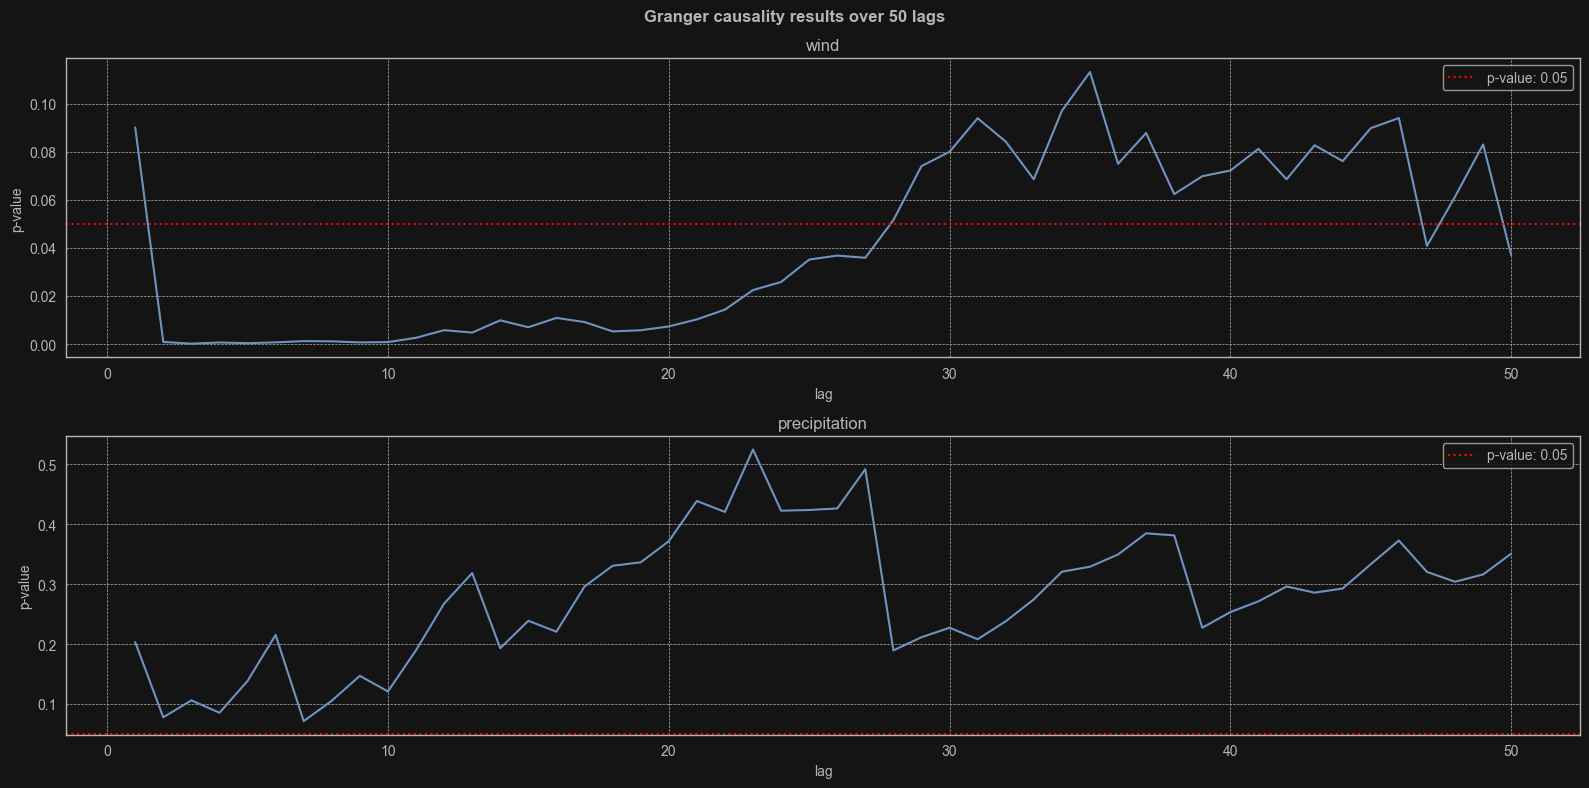

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
axes = axes.flatten()

n_lags = 50

for i, feature in enumerate(['wind', 'precipitation']):
    
    # shift the series from original dataframe because diff returns NAN value for first row
    wind_cut = df[feature].loc[temp_avg_diff.index]
    
    # create temporary dataframe for granger test
    granger_df = pd.DataFrame.from_dict({
        feature: wind_cut,
        'temp_avg': temp_avg_diff
    })

    # define granger test
    granger_wind_temp = granger(x=granger_df[[feature, 'temp_avg']], maxlag=n_lags, verbose=False)
    
    # get p_values from granger test
    p_values = [round(granger_wind_temp[lag+1][0]['ssr_ftest'][1], n_lags) for lag in range(n_lags)]
    p_values
    
    # plot
    sb.lineplot(x=[x for x in range(1, n_lags+1)], y=p_values, color=mid_blue, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_ylabel('p-value')
    axes[i].set_xlabel('lag')
    axes[i].axhline(y=0.05, color='red', ls=':', label='p-value: 0.05')
    axes[i].legend()
    
plt.suptitle(f'Granger causality results over {n_lags} lags', fontweight='bold')
plt.tight_layout()

Although the trend is kind of similar for both features, the precipitation is way above 0.05 threshold, indicating a low predictive impact on predicting temperature feature.

In [19]:
# removed date index column, because it can be interpreted the same way as index, the order remains unchanged
df.to_csv('../datasets/weather-processed.csv', index=False)